<hr>   
   
# Bigram Language Model
<hr>

In [1]:
import torch
import torch.nn.functional as F
import string
import numpy as np
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=120)
seed = 2**31 - 1

A **bigram language model** is a model that only works with **two characters** at the time. It models the conditional probabilities of the next character, given only the previous character.

In this notebook we develop two bigram models: 1) by **counting** and 2) by using a simple **neural network** with a single layer. The models receive a character as input and predict the next character in a sequence using a [Markov process](https://www.wikiwand.com/en/Markov_chain).  

The focus of this notebook is 1) introducing torch.Tensor and its subtleties and use in efficiently evaluating neural networks and 2) the overall framework of language modeling that includes model training, sampling, and the evaluation of a loss (e.g. the negative log likelihood for classification).



**Load the data**

In [2]:
# Load the data
with open('./data/names.txt', 'r') as f:
    names = f.read().splitlines()
print(f'Total # names: {len(names):.>25,}')
print(f"Total # characters in all names: {len(''.join(names)):,}")
print(names[:5])

Total # names: ...................32,033
Total # characters in all names: 196,113
['emma', 'olivia', 'ava', 'isabella', 'sophia']


Our data consists of 32,033 names, each with a length between 2 and 15 characters. To better understand the structure and patterns of the data at a character level, we can print the bigrams for the first 2 names. A bigram is a pair of consecutive characters in a string. By printing the bigrams for the first 2 names, we can gain a better understanding of what our model will be learning and predicting. 

In [3]:
for w in names[:2]:
    print(w)
    for [*bg] in zip(w[:-1], w[1:]):
        print(bg)

emma
['e', 'm']
['m', 'm']
['m', 'a']
olivia
['o', 'l']
['l', 'i']
['i', 'v']
['v', 'i']
['i', 'a']


**Padding**   
We need two special characters besides a..z to indicate the beginning \<S> and the end \<E> of a name. But because \<S> can never be an output and \<E> never an input we can simplify a little and use only one special character to indicate both the beginning and the end of a name. We choose "`.`" as special character.   
Our bigrams now look as follows:

In [4]:
for w in names[:2]:
    chs = ['.'] + list(w) + ['.']
    for [*bg] in zip(chs[:-1], chs[1:]):
        print(bg)
    print()

['.', 'e']
['e', 'm']
['m', 'm']
['m', 'a']
['a', '.']

['.', 'o']
['o', 'l']
['l', 'i']
['i', 'v']
['v', 'i']
['i', 'a']
['a', '.']



**Encoding and decoding characters**   
We define an encoder `ch2ix` and decoder `ix2ch` function that maps a character with a numerical representation (i.e. a unique integer) and vice-versa. 

In [5]:
chars = '.' + string.ascii_lowercase
ch2ix = {s: i for i, s in enumerate(chars)}
ix2ch = {i: s for s, i in ch2ix.items()}

print('Encoder ch2ix:\n', ch2ix)
print('Decoder ix2ch:\n', ix2ch)
print('E.g. emma:', [ch2ix[c] for c in '.emma.'])

Encoder ch2ix:
 {'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
Decoder ix2ch:
 {0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
E.g. emma: [0, 5, 13, 13, 1, 0]


## Counting Model

One way to learn the conditional probabilities of which character is likely to follow a previous character is to count the number of times a bigram occurs in our training set and then convert these counts into probabilities. This is known as counting bigram occurrences and is a simple method for learning these probabilities. By doing this, we can create a model that is able to predict the next character in a sequence based on the previous character.

### Train the model

**Counting**

In [6]:
bg_count: dict[tuple[str, str], int] = {}
for w in names:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs[:-1], chs[1:]):
        bg_count[(ch1, ch2)] = bg_count.get((ch1, ch2), 0) + 1
# sort by counts
a = sorted(bg_count.items(), key=lambda kv: kv[1], reverse=True)
print(a[:10])
print('...')
print(a[-10:])

[(('n', '.'), 6763), (('a', '.'), 6640), (('a', 'n'), 5438), (('.', 'a'), 4410), (('e', '.'), 3983), (('a', 'r'), 3264), (('e', 'l'), 3248), (('r', 'i'), 3033), (('n', 'a'), 2977), (('.', 'k'), 2963)]
...
[(('g', 'v'), 1), (('d', 'q'), 1), (('x', 'b'), 1), (('w', 'z'), 1), (('h', 'q'), 1), (('j', 'b'), 1), (('x', 'm'), 1), (('w', 'g'), 1), (('t', 'b'), 1), (('z', 'x'), 1)]


We see that the most frequent starting character for names are "`a`" and "`k`". The most frequent ending characters are "`n`" and "`a`". Note: the bigrams with 0 occurence are not counted here.  

Let's now represent the bigram counts in a 2D tensor as it allows for more efficient manipulation and analysis of the data. The rows of the tensor represent the previous character and the columns represent the next character, with the values being the bigram counts. By organizing the data in this way, we can easily access and analyze the frequency of different bigrams in the data. The tensor has a shape of (27, 27) because there are 26 characters plus one special character, giving a total of 27 different categories. This representation of the data allows us to more easily model the conditional probabilities of the next character given the previous character, which can be used to predict the next character in a sequence.

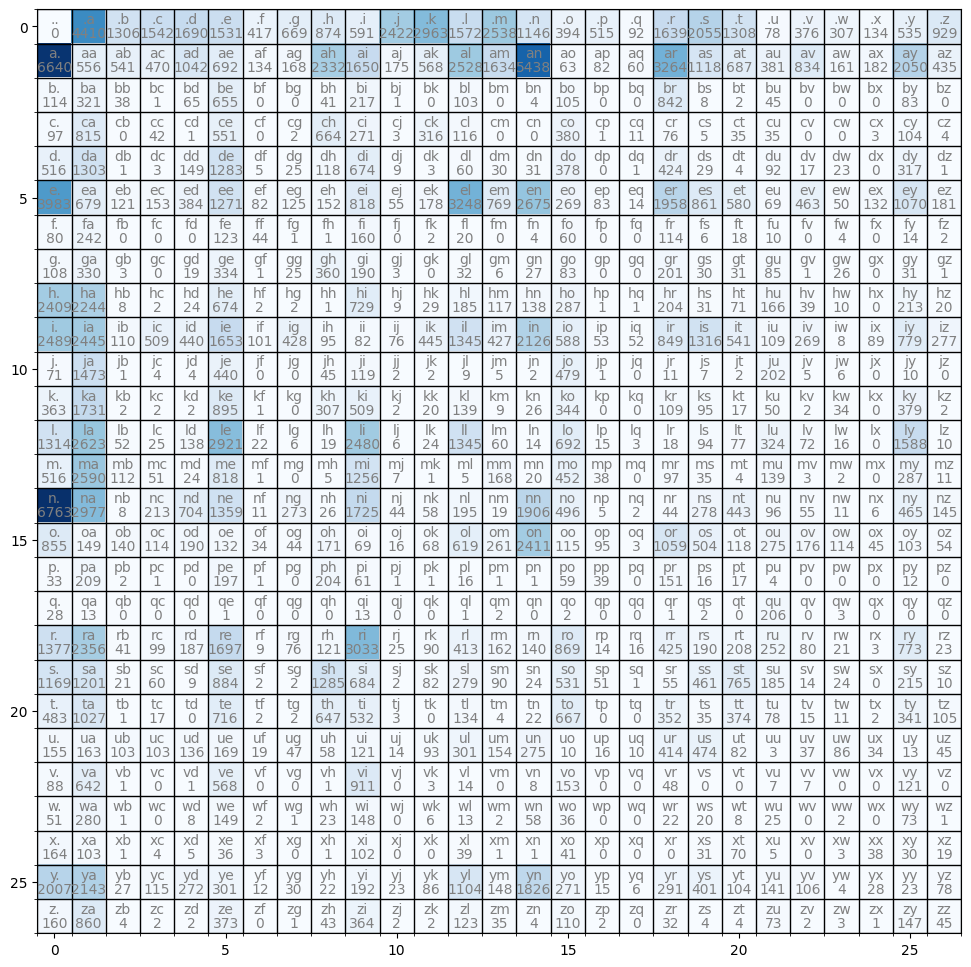

In [7]:
# Count all bigrams
N = torch.zeros((27, 27), dtype=torch.int32)
for w in names:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs[:-1], chs[1:]):
        ix1 = ch2ix[ch1]
        ix2 = ch2ix[ch2]
        N[ix1, ix2] += 1

# Plot the bigrams
plt.figure(figsize=(12, 12))
plt.imshow(N, cmap='Blues')
ax = plt.gca()
# Minor ticks
ax.set_xticks(np.arange(-0.5, 27, 1), minor=True)
ax.set_yticks(np.arange(-0.5, 27, 1), minor=True)
# Gridlines based on minor ticks
ax.grid(which='minor', color='black', linestyle='-', linewidth=1)
for i in range(27):
    for j in range(27):
        chstr = ix2ch[i] + ix2ch[j]
        plt.text(j, i, chstr, ha='center', va='bottom', color='grey')
        plt.text(j, i, str(N[i, j].item()), ha='center', va='top', color='gray')
plt.show()


In the **first row** [0, :] we find the counts for all the different **first characters**. F.i. 4,410 names start with "`a`", 2,963 with a "`k`", but only 78 with a "`u`". In the **first column** [:, 0] we find the counts for all **last characters**. F.i. 6,763 names end with "`n`", 6,640 with "`a`", but only 28 with "`q`". 


**Probabilities**

We can convert the bigram counts into probabilities by dividing each element in the tensor by the sum of all the elements in its corresponding row. This process allows us to express the frequency of each bigram as a probability, which can be used to predict the next character in a sequence based on the previous character. This is done by normalizing the count data across each row, which allows us to express the relative frequency of each bigram within the context of the previous character.    
$p_{ij} = \large\frac{n_{ij}}{\sum_{j=0}^{26}{n_{ij}}}$

```{note}
**Sum**: For a 2d tensor, the dim in [torch.tensor.sum](https://pytorch.org/docs/stable/generated/torch.sum.html#torch.sum) is the dimension we want to sum. So,`dim=0` calculates the sum of each column, `dim=1` the sum of each row.  
The way to understand this is that **it collapses the specified dim**. So when it collapses dim 1 (the column), the sum becomes just one
 column (it sums row wise).
If `keepdim=True`, the output tensor is of the same size as the input, except in the dimension(s) dim, where it is of size 1. If `keepdim=False`, the output dim is squeezed and the output has 1 (or len(dim)) fewer dimension(s)
```

```{note}
**Broadcasting**: N has dimension (27,27). `N.sum(dim=1,keepdim=True)` has dimention (27,1). It's not possible to devide a (27,27) tensor by a (27,1) tensor. Nevertheless `N / N.sum(dim=1,keepdim=True)` is valid because broadcasting stretches the (27,1) column vector into a (27,27) matrix by copying the column vector 27 times and then makes an element wise division.
```

In [8]:
P = N / N.sum(dim=1, keepdim=True)
P

tensor([[0.0000e+00, 1.3767e-01, 4.0770e-02, 4.8138e-02, 5.2758e-02, 4.7794e-02, 1.3018e-02, 2.0885e-02, 2.7284e-02,
         1.8450e-02, 7.5610e-02, 9.2498e-02, 4.9074e-02, 7.9231e-02, 3.5776e-02, 1.2300e-02, 1.6077e-02, 2.8720e-03,
         5.1166e-02, 6.4153e-02, 4.0833e-02, 2.4350e-03, 1.1738e-02, 9.5839e-03, 4.1832e-03, 1.6702e-02, 2.9001e-02],
        [1.9596e-01, 1.6408e-02, 1.5966e-02, 1.3870e-02, 3.0751e-02, 2.0422e-02, 3.9546e-03, 4.9579e-03, 6.8821e-02,
         4.8694e-02, 5.1645e-03, 1.6763e-02, 7.4605e-02, 4.8222e-02, 1.6048e-01, 1.8592e-03, 2.4199e-03, 1.7707e-03,
         9.6326e-02, 3.2994e-02, 2.0274e-02, 1.1244e-02, 2.4613e-02, 4.7514e-03, 5.3711e-03, 6.0499e-02, 1.2838e-02],
        [4.3100e-02, 1.2136e-01, 1.4367e-02, 3.7807e-04, 2.4575e-02, 2.4764e-01, 0.0000e+00, 0.0000e+00, 1.5501e-02,
         8.2042e-02, 3.7807e-04, 0.0000e+00, 3.8941e-02, 0.0000e+00, 1.5123e-03, 3.9698e-02, 0.0000e+00, 0.0000e+00,
         3.1834e-01, 3.0246e-03, 7.5614e-04, 1.7013e-02, 0.000

### Sampling from the model

The tensor P contains all of the necessary information to sample from our bigram model. The elements of P represent the parameters of our language model and can be used to generate new names by sampling from the model. This is done by starting with the token "." and then looking at the first row in P, which contains the probabilities for every possible next character. We then sample the next character from this probability distribution and look at its corresponding row in P. We continue this process of sampling and iterating through the rows of P until we sample a "." indicating the end of the name. This process allows us to generate new names by sampling from the probability distributions represented in P, which are based on the frequency of bigrams in the training data.   
```{note}
We use [torch.multinomial](https://pytorch.org/docs/stable/generated/torch.multinomial.html) for sampling (multinomial distribution is a generalization of the binomial distribution).
```
Let's now generate a few names:

In [9]:
from numbers import Number
from typing import Any, Literal


g = torch.Generator().manual_seed(seed)

for i in range(10):
    out = []
    ix = 0  # The start token.
    while True:
        p = P[ix]  # type: ignore
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(ix2ch[ix])  # type: ignore
        if ix == 0:  # The end token.
            break
    print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.
odaren.
iaddash.
h.
jhinatien.
egushl.


The generated names produced by our bigram model are of poor quality, which is due to the limitations of the bigram model itself.   
However, when we compare the performance of the bigram model with a model that simply samples characters uniformly (where each character has an equal probability of 1/27 of being selected as the next character), we can see that the bigram model is actually able to capture some meaningful patterns and structure in the data. This suggests that the bigram model is able to provide some level of prediction accuracy, even if it is not able to produce high-quality names.

In [10]:
g = torch.Generator().manual_seed(seed)

for i in range(10):  # 10 names.
    out = []
    ix = 0  # The start token.
    while True:
        p = torch.ones(27) / 27.0  # Uniform distribution.
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(ix2ch[ix])  # type: ignore
        if ix == 0:  # Now the end token.
            break
    print(''.join(out))


qvsaayxbqrqmyqwuznivanukotdjvdhd.
qnoymtzduqkatdetkpfjdgigvlejfkrsqlwnirghhzwlu.
idcx.
cekmzucjnjoeovjvrggqrjr.
cfbhabkslpokc.
xtxwbpmknuusxdgzfexhwqpldpdnwzvkyxsqjforqqpfxstwkfoufhvwfhmsuyyotvcvvqpfcbydjcouhkajkhqnnpqmmllaordqy.
gszpw.
zlgijinangzzuulsyvqrufuawavsdbnwvlmrypvgrsfgpshgnmwafqmsjdvbhngvoiigxhkwdltrdkwnagzyknqv.
lfstdqigvncdoidetsukgdp.
cfpjsxeqjcsmjwguzes.


### Loss function


We now want to **evaluate the quality** of our model and summerize it into a **single number**. 

A very good model is a model that is very good at predicting the next character given the previous one. In other words for every bigram $(c_i, c_{i+1})$ of every name in our traininset: $p(c_{i+1}|c_i)\approx1$.   

Now how can we summerize all these probabilities into a single number?
- If we have a good model the product of all the probabilities or likelihood should be very high.  
- Because all probabilities are between 0 and 1, the product of the probabilities will be a tiny number. 
- Therefore we take the log-likelihood instead = $\log(\prod p(x)) = \sum \log(p(x))$
- If all probabilities are 1, log-likelihood is 0. If the probabilities are less than 1, the likelihood is more negative.
- To get a loss function:
  - maximize the **likelihood** w.r.t. the model parameters (statistical modeling).
  - equivalent to maximizing **log-likelihood** (because log is monotonic).
  - equivalent to minimizing the **negative log-likelihood**.
  - equivalent to minimizing the **average negative log-likelihood**.
  


```{note}
The [likelihood](https://www.wikiwand.com/en/Likelihood_function) $\mathcal{L}(\theta|X)$ represents the probability of random variable realizations conditional on particular values of the statistical parameters $\theta$.     
Likelihood is the hypothetical probability that an event that has already occurred would yield a specific outcome. The concept differs from that of a probability in that a probability refers to the occurrence of future events, while a likelihood refers to past events with known outcomes. 
In other words, when $f_{\theta}(x)$ is viewed as a function of $x$ with $\theta$  fixed, it is a probability density function $P(x|\theta)$, and when viewed as a function of $\theta$  with $x$ fixed, it is a likelihood function $\mathcal{L}(\theta|X)$.    
The likelihood function does not specify the probability that $\theta$  is the truth, given the observed sample $X=x$. Such an interpretation is a common error!!  
If the random variables are independent, then the joint-distribution is the product of the distribution of each of the individual random variables or marginals.   
$\mathcal{L}(\theta|X) = \prod p_{\theta}(x)$.

For intuitive explainations see: https://towardsdatascience.com/likelihood-probability-and-the-math-you-should-know-9bf66db5241b.
```




In [11]:
log_likelihood = 0.0
n = 0
for w in names:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs[:-1], chs[1:]):
        ix1 = ch2ix[ch1]
        ix2 = ch2ix[ch2]
        prob = P[ix1, ix2]
        log_prob = torch.log(prob)
        log_likelihood += log_prob.item()
        n += 1

print(f'log_likelihood: {log_likelihood:,.0f}')
nll = -log_likelihood
print(f'nll: {nll:,.0f}')
print(f'mean nll: {nll / n:.4f}')

log_likelihood: -559,874
nll: 559,874
mean nll: 2.4540


**Problem**: The loss goes to infinity when a bigram has zero probability. 

The bigram 'cb' in following example has 0 probability, hence the log-likelihood is $\infty$. 

In [12]:
log_likelihood = 0.0
n = 0
for w in ['marcb']:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs[:-1], chs[1:]):
        ix1 = ch2ix[ch1]
        ix2 = ch2ix[ch2]
        prob = P[ix1, ix2]
        log_prob = torch.log(prob)
        log_likelihood += log_prob.item()
        n += 1
        print(f'{ch1}{ch2}: {prob:.3f} {log_prob:.3f}')

print(f'log_likelihood: {log_likelihood:,.0f}')
nll = -log_likelihood
print(f'nll: {nll:,.0f}')
print(f'mean nll: {nll / n:.2f}')

.m: 0.079 -2.535
ma: 0.390 -0.942
ar: 0.096 -2.340
rc: 0.008 -4.854
cb: 0.000 -inf
b.: 0.043 -3.144
log_likelihood: -inf
nll: inf
mean nll: inf


**Solution: Smoothing**   
Add 1 or more to the counts. The bigger the number you add, the smoother the model becomes. 

In [13]:
smooth = 1
Psmooth = (N + smooth) / (N + smooth).sum(dim=1, keepdim=True)
log_likelihood = 0.0
n = 0
for w in ['marcb']:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs[:-1], chs[1:]):
        ix1 = ch2ix[ch1]
        ix2 = ch2ix[ch2]
        prob = Psmooth[ix1, ix2]
        logprob = torch.log(prob)
        log_likelihood += logprob.item()
        n += 1
        print(f'{ch1}{ch2}: {prob:.3f} {logprob:.3f}')

print(f'log_likelihood: {log_likelihood:,.0f}')
nll = -log_likelihood
print(f'nll: {nll:,.0f}')
print(f'mean nll: {nll / n:.2f}')

.m: 0.079 -2.536
ma: 0.389 -0.945
ar: 0.096 -2.341
rc: 0.008 -4.846
cb: 0.000 -8.177
b.: 0.043 -3.146
log_likelihood: -22
nll: 22
mean nll: 3.67


If the smooting number is very high then the distribution becomes more uniform and the output more random.

In [14]:
smooth = 1000
Psmooth = (N + smooth) / (N + smooth).sum(dim=1, keepdim=True)

for i in range(10):  # 10 names.
    out = []
    ix = 0  # The start token.
    while True:
        p = Psmooth[ix]  # type: ignore
        ix = torch.multinomial(p, num_samples=1, replacement=True).item()
        out.append(ix2ch[ix])  # type: ignore
        if ix == 0:  # Now the end token.
            break
    print(''.join(out))


zjjheyxpgahrmduqk.
d.
hfqgpngjrietewbnee.
wwizb.
rmzue.
xohdxxnuunqyuxasdgfjwjgwla.
mzadufjneyufpxozaspebrijeyarhbyfzxvh.
dt.
elnlkkzkmsbaqre.
lligarrhdqnbimafuddovylkmkrbxdtloslemtidffnafrttis.


## Neural Network Model

We will now frame the problem of bigram character-level language modeling within the neural network framework. We will approach this problem in a slightly different way, but ultimately arrive at a similar position as with our counting model. Our neural network will take a single character as input, use a set of parameters (weights) W, and output a probability distribution over the next character in the sequence. We know the true next character and want the output probability for it to be as high as possible, which is equivalent to minimizing the negative log-likelihood loss. To optimize the weights of the network and achieve this goal, we will use gradient-based optimization to tune the weights such that the negative log-likelihood loss is minimized.

### Building NN step by step

**Trainingset**: We create a trainingset of all the bigrams. It contains two lists, the inputs `xs` and the targets `ys`.   
We will start with just one name to better see how the neural network is build step-by-step.

In [15]:
xs, ys = [], []
for w in names[:1]:
    print(f'The bigrams for name: {w}:')
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs[:-1], chs[1:]):
        ix1 = ch2ix[ch1]
        ix2 = ch2ix[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2)
print('The dataset:')
xs = torch.tensor(xs)
ys = torch.tensor(ys)

print(f'{xs=}\n{ys=}')


The bigrams for name: emma:
. e
e m
m m
m a
a .
The dataset:
xs=tensor([ 0,  5, 13, 13,  1])
ys=tensor([ 5, 13, 13,  1,  0])


There are 5 separate input examples in this dataset. When we input 0 ("`.`") into the networks, we want it's weights to be arranged so that 5 ("`e`") gets a high probability, when we input 13 we want high probability for 1 ("`m`") and a high probability for 1 ("`a`"). 

**One-hot encodings**: In order to use the integer character indexes as input in a neural network, we need to use a technique called [one-hot encoding](https://www.wikiwand.com/en/One-hot). One-hot encoding is a way of representing categorical data (such as integer indexes or characters) as a vector of binary values. A one-hot vector for a character with index `ix` has all zero values except for the ix-th element, which is set to 1. This encoding method is used because it avoids implying a natural ordering between different characters (for example, "`a`" < "`b`"), which would not be meaningful in this context. Additionally, it is not desirable to have the input neurons take on integer values that are then multiplied by the weights, as this would not provide useful information to the model. PyTorch provides a function ([torch.nn.functional.one_hot()](https://pytorch.org/docs/stable/generated/torch.nn.functional.one_hot.html)) to one-hot encode integers.  

One-hot encoding for tensor([ 0,  5, 13, 13,  1])
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


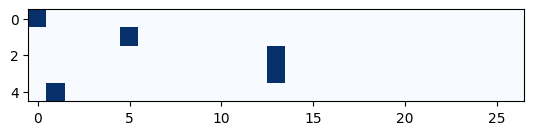

In [16]:
xenc = F.one_hot(xs, 27).float()
print(f'One-hot encoding for {xs}')
print(xenc)
plt.imshow(xenc, cmap='Blues')
plt.show()

**1 neuron**: The neuron will look at the input vectors (`xenc`) and perform a simple linear function $W\cdot x+b$.   
We create a (27,1) weight W and initialize it with a normal distribution using [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html). W is a column vector with 27 numbers. When we do a matrix multiplication of our input `xenc` (5,27) with `W` (27,1) we get 1 neuron with 5 (=batchsize) activations, one for each input vector.     

In [17]:
W = torch.randn(27, 1)
print(f'(5,27) . (27,1) -> (5,1)')
print(xenc @ W)

(5,27) . (27,1) -> (5,1)
tensor([[-0.2176],
        [ 0.2517],
        [ 1.2141],
        [ 1.2141],
        [-1.2015]])


**27 neurons**: In stead of only 1 neuron we would like to have 27. The shape of `W` will be (27,27). Each neuron has its 27 weights in the columns of `W`. We evaluate in parallel all the 27 neurons on all the 5 inputs, which is very efficient. Our output is now (5,27) . (27,27) -> (5, 27). Each element of the output is telling us what the firing rate of those neurons are on every one of the five samples. 

In [18]:
W = torch.randn(27, 27)
print(f'(5,27) . (27,27) -> (5,27)')
print(xenc @ W)

(5,27) . (27,27) -> (5,27)
tensor([[ 0.3492,  0.0655,  0.3812,  1.4309,  0.6050,  0.2704,  2.4598,  0.3496, -0.3781, -0.1295, -0.5569, -0.5175,
          2.6120, -0.5314, -0.0773,  1.5547, -1.6495,  0.8602, -0.8546,  0.7089, -1.5309,  0.7062, -0.2390,  1.8540,
         -0.3423, -0.8785, -0.2678],
        [-0.7606, -1.6208, -1.2376,  0.6203, -1.4803,  0.9769,  1.0299, -1.0603, -0.4021,  0.4907,  1.8731, -0.1639,
          2.0216,  1.6673, -0.3785, -1.0568,  2.7153, -2.2130, -1.9582, -1.1643, -1.3517, -0.3833,  0.6396,  1.5745,
          1.0158,  0.6076,  0.9357],
        [-1.3656, -0.1813,  0.1459, -1.0900,  0.8762,  1.1151, -1.6163, -0.2267,  1.3320,  0.3232,  0.1221,  0.8284,
         -0.7818, -0.4348, -1.3194, -2.3545,  0.1126,  1.5646,  1.5115, -1.6008,  0.6315,  0.1946,  0.5464, -0.4027,
         -0.6687, -1.2158, -0.1634],
        [-1.3656, -0.1813,  0.1459, -1.0900,  0.8762,  1.1151, -1.6163, -0.2267,  1.3320,  0.3232,  0.1221,  0.8284,
         -0.7818, -0.4348, -1.3194, -2.3545

E.g. Element [3,13] from the output gives us the firing rate of the 13th neuron of the 3th input. It was achieved by the dot product of the 3th input and the 13th column of W.

In [19]:
print(f'Element [3,13] from the output: {(xenc @ W)[3, 13]:.4f}')
# Let's verify
print(f'Input 3: {xenc[3]}')
print(f'Column 13 of W: {W[:, 13]}')
print(f'Dot product of input 3 with column 13 of W: {xenc[3] @ W[:, 13]:.4f}')

Element [3,13] from the output: -0.4348
Input 3: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
Column 13 of W: tensor([-0.5314, -0.9603,  0.6747,  1.5882, -2.2961,  1.6673, -1.7412, -0.6247,  0.0720, -0.9983, -1.6628, -1.0896,
        -0.8744, -0.4348,  0.5732,  0.6638,  0.9935,  0.9466,  1.2713, -1.1280,  0.5499, -0.3745,  0.7821,  0.0523,
        -0.3808, -1.5677,  0.2049])
Dot product of input 3 with column 13 of W: -0.4348


**Output probabilities**: We now have a very simple neural network with a single linear layer and 27 inputs and 27 neurons. These neurons perform `W.x`, they don't have a bias and they don't have non-linearity.   
Intuitively, we want to produce for every single input sample, a probability distribution for the 27 possible next characters in the sequence. For the moment our output has positive and negative numbers. They can't be interpreted as counts because counts are positive. The also can't be interpreted as probabilities because they can be smaller than 0 and bigger than 1 and they don't sum up to 1. So we need to transform the outputs into numbers that sum to 1 and are between 0 and 1.   
- We can interprete the output as log-counts `logits`. 
- To get something we can interprete as counts we exponentiate the log-counts. Negative numbers are be mapped to numbers netween 0 and 1. Positive numbers into numbers between 1 and $\infin$. These `counts` are equivalent to the `N` counts array.
- To obtain probabilities from the counts, we can normalize the counts so that they sum to 1 and are between 0 and 1. This will allow us to interpret the output of the network as a valid probability distribution over the possible next characters in the sequence.


In [20]:
logits = xenc @ W  # log-counts
counts = logits.exp()  # counts equivalent N
probs = counts / counts.sum(1, keepdims=True)
print(f'{probs=}')
print('Verification all rows sum to 1:')
print(probs.sum(1))


probs=tensor([[0.0224, 0.0169, 0.0231, 0.0661, 0.0289, 0.0207, 0.1848, 0.0224, 0.0108, 0.0139, 0.0090, 0.0094, 0.2152, 0.0093,
         0.0146, 0.0748, 0.0030, 0.0373, 0.0067, 0.0321, 0.0034, 0.0320, 0.0124, 0.1008, 0.0112, 0.0066, 0.0121],
        [0.0074, 0.0031, 0.0046, 0.0296, 0.0036, 0.0422, 0.0446, 0.0055, 0.0106, 0.0260, 0.1035, 0.0135, 0.1201, 0.0843,
         0.0109, 0.0055, 0.2403, 0.0017, 0.0022, 0.0050, 0.0041, 0.0108, 0.0302, 0.0768, 0.0439, 0.0292, 0.0405],
        [0.0069, 0.0226, 0.0314, 0.0091, 0.0651, 0.0827, 0.0054, 0.0216, 0.1028, 0.0375, 0.0306, 0.0621, 0.0124, 0.0176,
         0.0072, 0.0026, 0.0304, 0.1297, 0.1230, 0.0055, 0.0510, 0.0329, 0.0468, 0.0181, 0.0139, 0.0080, 0.0230],
        [0.0069, 0.0226, 0.0314, 0.0091, 0.0651, 0.0827, 0.0054, 0.0216, 0.1028, 0.0375, 0.0306, 0.0621, 0.0124, 0.0176,
         0.0072, 0.0026, 0.0304, 0.1297, 0.1230, 0.0055, 0.0510, 0.0329, 0.0468, 0.0181, 0.0139, 0.0080, 0.0230],
        [0.0459, 0.0253, 0.0064, 0.0136, 0.0015, 0.018

**Softmax**: The 2 operations
```python
counts = logits.exp()
probs = counts/counts.sum(dim=1,keepdim=True)
```
is called the [softmax](https://en.wikipedia.org/wiki/Softmax_function).

$\text{softmax}(x_i) = \Large\frac{e^{x_i}}{\sum_j{e^{x_j}}}$

**Summary**

In [21]:
print(f'Inputs:  {xs}')
print(f'Targets: {ys}')
# One-hot encode the input.
xenc = F.one_hot(xs, num_classes=27).float()  # (5,27)

Inputs:  tensor([ 0,  5, 13, 13,  1])
Targets: tensor([ 5, 13, 13,  1,  0])


In [22]:
# Randomly initialize 27 neurons weights; each neuron receives 27 inputs.
g = torch.Generator().manual_seed(seed)
W = torch.randn((27, 27), generator=g)

In [23]:
# Forward pass:
# Predict the log-counts.
logits = xenc @ W  # (5,27)
# Get the counts, equivalent to N
counts = logits.exp()  # (5,27)
# Get the probabilities for next character.
probs = counts / counts.sum(dim=1, keepdim=True)  # (5,27)

In [24]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram:
    x = xs[i].item()  # input character index
    y = ys[i].item()  # label character index
    print('--------')
    print(f'bigram example {i+1}: {ix2ch[x]}{ix2ch[y]} (indexes {x},{y})')  # type: ignore
    print('input to the neural net:', x)
    print('output probabilities from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i, y]
    print('probability assigned by the net to the the correct character:', p.item())
    logp = torch.log(p)
    print('log likelihood:', logp.item())
    nll = -logp
    print('negative log likelihood:', nll.item())
    nlls[i] = nll

print('=========')
print('average negative log likelihood, i.e. loss =', nlls.mean().item())

--------
bigram example 1: .e (indexes 0,5)
input to the neural net: 0
output probabilities from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137, 0.0313, 0.0079, 0.0278, 0.0091, 0.0082,
        0.0500, 0.2378, 0.0603, 0.0025, 0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net to the the correct character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------
bigram example 2: em (indexes 5,13)
input to the neural net: 5
output probabilities from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097, 0.0301, 0.0702, 0.0228, 0.0115, 0.0181,
        0.0108, 0.0315, 0.0291, 0.0045, 0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net to the the correct character: 0.0180507004261016

### Optimization

**Minimize the loss**: The loss, or mean negative log-likelihood, is composed of differential operations, which means that it can be minimized by adjusting the weights of W. This process, known as tuning, involves calculating the gradients of the loss with respect to the weights and using these gradients to update the weights in a way that reduces the loss. By minimizing the loss, we can improve the performance of the model and increase its ability to accurately predict the next character in a sequence based on the previous character.

In [25]:
# Create the full dataset
xs, ys = [], []
for w in names:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = ch2ix[ch1]
        ix2 = ch2ix[ch2]
        xs.append(ix1)
        ys.append(ix2)
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

print('number of bigrams: ', num)

number of bigrams:  228146


In [26]:
# Randomly initialize 27 neurons weights; each neuron receives 27 inputs.
g = torch.Generator().manual_seed(seed)
W = torch.randn((27, 27), generator=g, requires_grad=True)

In [27]:
loss = torch.tensor(0)
for k in range(10000):
    # forward pass
    # input to the network: one-hot encoding
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W  # predict log-counts
    counts = logits.exp()  # counts, equivalent to N
    # probabilities for next character
    probs = counts / counts.sum(1, keepdims=True)
    # probs[torch.arange(num), ys] is the probability the net assigns to the target.
    loss = -probs[torch.arange(num), ys].log().mean()

    # backward pass
    W.grad = None  # set to zero the gradient
    loss.backward()
    # update
    W.data += -50 * W.grad  # type: ignore

print('loss: ', loss.item())


loss:  2.454146385192871


```{note}
If we train long enough then we obtain the same loss (2.454) by gradient based optimization as by counting.
```

Moreover, we can verify that `W.exp()` is similar to `N` and `W.exp()/W.exp().sum(1,True)` is similar to `P`. 

$\large e^{w_{ij}}=c_i n_{ij} $

$\large \frac{e^{w_{ij}}}{\sum_j w_{ij}} = p_{ij}$


In [28]:
W.exp() / N

tensor([[       inf, 2.2393e-03, 2.2393e-03, 2.2393e-03, 2.2393e-03, 2.2393e-03, 2.2392e-03, 2.2393e-03, 2.2393e-03,
         2.2393e-03, 2.2393e-03, 2.2393e-03, 2.2393e-03, 2.2393e-03, 2.2393e-03, 2.2392e-03, 2.2393e-03, 2.2389e-03,
         2.2393e-03, 2.2393e-03, 2.2393e-03, 2.2388e-03, 2.2392e-03, 2.2392e-03, 2.2390e-03, 2.2393e-03, 2.2393e-03],
        [1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03,
         1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03,
         1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03, 1.4188e-03],
        [1.6511e-01, 1.6526e-01, 1.6465e-01, 1.4425e-01, 1.6494e-01, 1.6530e-01,        inf,        inf, 1.6470e-01,
         1.6522e-01, 1.4479e-01,        inf, 1.6509e-01,        inf, 1.5767e-01, 1.6509e-01,        inf,        inf,
         1.6531e-01, 1.6189e-01, 1.4712e-01, 1.6476e-01,      

In [29]:
(W.exp() / W.exp().sum(1, True)).round(decimals=3) - P.round(decimals=3)


tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0010,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000, -0.0010,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0010

### Sampling names

In [30]:
g = torch.Generator().manual_seed(seed)

for i in range(5):

    out = []
    ix = 0  # '.'
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W  # predict log-counts
        counts = logits.exp()  # counts, equivalent to N
        # probabilities for next character
        p = counts / counts.sum(1, keepdims=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(ix2ch[ix])  # type: ignore
        if ix == 0:
            break
    print(''.join(out))

mor.
axx.
minaymoryles.
kondlaisah.
anchshizarie.


### Smoothing the neural network: regularization

In the simple counting model, we smoothed the probability distributions by adding fake counts, which made the distributions more uniform. In the gradient-based model, we can achieve a similar effect by adding a regularization component to the loss function that incentivizes the elements of W to be near 0. This is equivalent to label smoothing, as setting the elements of W to 0 leads to uniform probability distributions (with all elements equal to 1). We can do this by adding a term such as `(W**2).mean()` to the loss function, which will be minimized along with the main loss term. This will encourage the elements of W to become closer to 0, which will smooth the probability distributions produced by the model. As a result, the loss function now has two components: one that tries to get the probabilities right and another that simultaneously tries to make all of the elements of W close to 0.

In [31]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), generator=g, requires_grad=True)

for k in range(1000):
    # forward pass
    # input to the network: one-hot encoding
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W  # predict log-counts
    counts = logits.exp()  # counts, equivalent to N
    # probabilities for next character
    probs = counts / counts.sum(1, keepdims=True)

    main_loss = -probs[torch.arange(num), ys].log().mean()
    reg_loss = .10 * (W**2).mean()
    loss = main_loss + reg_loss
    print(f'{k:<5} | total loss: {loss.item():.6f} | main loss: {main_loss:.6f} | regul. loss: {reg_loss:.6f}')
    # backward pass
    W.grad = None  # set to zero the gradient
    loss.backward()

    # update
    W.data += -50 * W.grad  # type: ignore


0     | total loss: 3.855605 | main loss: 3.758954 | regul. loss: 0.096652
1     | total loss: 3.446014 | main loss: 3.361175 | regul. loss: 0.084839
2     | total loss: 3.220781 | main loss: 3.141910 | regul. loss: 0.078871
3     | total loss: 3.083401 | main loss: 3.008003 | regul. loss: 0.075398
4     | total loss: 2.989142 | main loss: 2.915893 | regul. loss: 0.073248
5     | total loss: 2.921294 | main loss: 2.849357 | regul. loss: 0.071937
6     | total loss: 2.870577 | main loss: 2.799466 | regul. loss: 0.071111
7     | total loss: 2.831214 | main loss: 2.760632 | regul. loss: 0.070581
8     | total loss: 2.799692 | main loss: 2.729444 | regul. loss: 0.070248
9     | total loss: 2.773835 | main loss: 2.703776 | regul. loss: 0.070059
10    | total loss: 2.752247 | main loss: 2.682263 | regul. loss: 0.069984
11    | total loss: 2.733991 | main loss: 2.663990 | regul. loss: 0.070001
12    | total loss: 2.718407 | main loss: 2.648315 | regul. loss: 0.070092
13    | total loss: 2.705

In [32]:
g = torch.Generator().manual_seed(seed)

for i in range(5):

    out = []
    ix = 0  # '.'
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W  # predict log-counts
        counts = logits.exp()  # counts, equivalent to N
        # probabilities for next character
        p = counts / counts.sum(1, keepdims=True)
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(ix2ch[ix])  # type: ignore
        if ix == 0:
            break
    print(''.join(out))

mor.
axx.
minaynnnyles.
koneraisah.
andhumizarie.
